# Directional Selectivity in the Drosophila Visual System

In [1]:
from __future__ import division

from libSpineML import smlExperiment as exp
from libSpineML import smlNetwork as net
from libSpineML import smlComponent as com
from libSpineML.smlUtils import  create_spineml_network
from libSpineML.smlUtils import  process_connection_json

from libSpineML.smlUtils import  extract_adjacency_matrix
from libSpineML.smlUtils import  inject_adjacency_matrix
from libSpineML.smlUtils import set_esn_weights
from libSpineML.smlUtils import load_sc_data

from matplotlib import pyplot as plt

import csv
import sys

import cStringIO
import graphviz as gv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import copy
import pickle


lpu_dict = pickle.load(( open( "../neuroarch_example/spineml/lpu_dicts.p", "rb" ) ))
connections_json = pickle.load(( open( "../neuroarch_example/spineml/example_connections_json.p", "rb" ) ))

# Build an ESN implementation

We can pass in a custom neuron parameters dictionary to specify the ESN network components


In [2]:
from utils import *

neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{'w':0.2},
                             'input_src_port':"activation",
                             'input_dst_port':"in"
                            
                            
                            },
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml',
                            'input_src_port':"out",
                             'input_dst_port':"I",
                             'output_src_port':"I_in",
                             'output_dst_port':"Input"                           
                            
                            },
                         'input_model':
                            {'name':'ESNInput', 'filename':'ESNInput.xml'}
                }

In [3]:
trial_length = 100
path_start = 0.3
path_end = 0.7

n_trials = 100
n_classes = 2

n_outputs = 13

shuffle_trials = True

In [4]:
image = bars_signal(n=100,on_size=3,off_size=10,on_val = 0.5,off_val = 0.1)

centers = {}
    
# Move X directions
centers[0] = generate_centers(trial_length, path_start = path_start,path_end = path_end)
# Move Y directions
centers[1] = generate_centers(trial_length, path_start = path_start,path_end = path_end)
# Move X directions
centers[2] = generate_centers(trial_length, path_start = path_end,path_end = path_start)
# Move Y directions
centers[3] = generate_centers(trial_length, path_start = path_end,path_end = path_start)

images = {}
trials = []


t = 0
for i in np.arange(n_trials):
    trials.append(np.mod(t, n_classes))
    t+=1
    if t == n_outputs:t=0

if shuffle_trials:
    from random import shuffle
    shuffle(trials)


trial_data = []
trial_class = []
image_backup = image.copy()

for trial in trials:
    cs = centers[trial]

    # Reversing trials
    if trial == 1  or trial == 3: 
        image = image_backup.T.copy()
    else:
        image = image_backup.copy()

    images[trial] = image
    data, classes, ps, names = single_trial(image, cs,input_class=trial,hex_radius =0.03)

    trial_data.append(data)
    trial_class.append(classes)

    experiment_classes = np.hstack(trial_class)

    experiment_targets= -np.ones((n_outputs,experiment_classes.shape[0]))

    for i,c in enumerate(experiment_classes):
        experiment_targets[c,i] = 1

    experiment_data = np.ones((trial_data[0].shape[0]*len(trial_data),trial_data[0].shape[1]))

    for i,d in enumerate(trial_data):
        experiment_data[i*trial_data[0].shape[0]:(i+1)*trial_data[0].shape[0],:] = d

    experiment_data =experiment_data.T

    trainlen = experiment_targets.shape[1]/2
    future =  experiment_targets.shape[1]/2



## 1. Identify all the input nodes and their connections


In [5]:
cartridges = [k.split('-')[1] for k in connections_json['nodes'].keys() if 'L1' in k]

# Reorder these to fit Input generation 
cartridges.remove(u'home')
cartridges.sort()
cartridges = ['home'] + cartridges

input_neurons = ['L1','L2','L4']

input_nodes = []

for c in cartridges:
    name = str("Input_%s" % c).encode('utf8')
    input_nodes.append(name)
    connections_json['nodes'][name] = {u'class':  u'Input', u'name': name , u'uname': name}

# Add input connections

# for every Input node
for c in cartridges:
    for n in input_neurons:
        pre = str("Input_%s" % c).encode('utf8')
        post = "%s-%s" %(n,c)
        if post in connections_json['nodes'].keys():
            if pre not in connections_json['edges']: connections_json['edges'][pre] ={}
            if post not in connections_json['edges'][pre]: connections_json['edges'][pre][post] ={}
            connections_json['edges'][pre][post] = {u'inferred': 0, u'synapses': 1}


 Adding Input Node: Input_R  
 Adding Input Node: Input_D  
 Adding Input Node: Input_E  
 Adding Input Node: Input_B  
 Adding Input Node: Input_C  
 Adding Input Node: Input_A  
 Adding Input Node: Input_L  
 Adding Input Node: Input_J  
 Adding Input Node: Input_K  
 Adding Input Node: Input_P  
 Adding Input Node: Input_Q  
 Adding Input Node: Input_F  
 Adding Input Node: Input_home  
Creating SpineML representation...
Creating ESN weights...
done


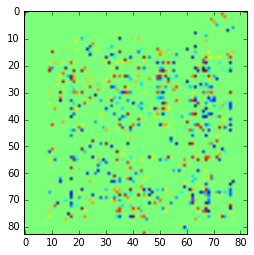

In [6]:

neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."

spectral_radius=1.0
print "Creating ESN weights..."
populations,projections,adjacency_matrix = set_esn_weights(populations,projections, spectral_radius=1.0,weight_parameter='w')

project = create_spineml_network(neurons, populations,
projections,output_filename='model.xml',network_name='model',project_name= 'drosophila')
print "done"

adjacency_matrix, neuron_index = extract_adjacency_matrix(populations,projections, weight_parameter='w')
plt.imshow(adjacency_matrix)
plt.show()

# Create an Experiment with Input

In [18]:
steps = experiment_data.shape[1]
#steps = 100
print steps
dt = 0.2

SpineMLExperiment = exp.SpineMLType()
experiment = exp.ExperimentType()
experiment.name = "ESN"
experiment.description = "NeuroNLP-spineML bridge"
sim = exp.SimulationType(duration=str((steps*dt)/1000),preferred_simulator='BRAHMS')

IM = exp.EulerIntegrationType(dt=str(dt))

sim.AbstractIntegrationMethod = IM
experiment.Simulation = sim



#TODO set Integration MEthod: exp.EulerIntegrationType(dt=1)

input_signals = {i : experiment_data[i,0:steps] for i,n in enumerate(input_nodes)}


#for i in input_nodes:
for i,c in enumerate(cartridges):
    # Create a Time Varying Array
    tv = exp.TimeVaryingInputType(
        name="%s_data" % c,
        target="Input_%s" % c,
        target_indices=0,
        port='Input',
        start_time=str(0),
        duration=str(steps*dt)
    )
    
    #for time,value in enumerate(input_signals[i]):
    for time,value in enumerate(experiment_data[i]):
        tv.add_TimePointValue(exp.TimePointValueType(time=str(dt*time),value=str(value)))
    
    experiment.add_AbstractInput(tv)
    
for p in populations.keys():
    
    out = exp.LogOutputType()
    out.set_name("%s_Output" % p)
    out.set_target(p)
    out.set_port('activation')
    out.start_time=0
    out.end_time=1e+08
    
    experiment.add_AbstractOutput(out)
    
model = exp.ModelType()
model.network_layer_url = 'model.xml'
experiment.Model = model

    
SpineMLExperiment.add_Experiment(experiment)

10000


# Create a Project File

In [19]:
from libSpineML import smlBundle

In [20]:
b = smlBundle.Bundle()
b.add_experiment(SpineMLExperiment)

b.add_network(project['network']['component']);

b.add_component(component='ESN_files/ESNInput.xml')
b.add_component(component='ESN_files/ESNNode.xml')
b.add_component(component='ESN_files/ESNWeight.xml')
b.add_component(component='ESN_files/ESNConnection.xml')
b.create_project()

b.export_project('project.proj',project_file='test_project/')

In [26]:
from subprocess import call
project_folder = 'test_project'
call(['./run_experiment.sh',  project_folder])  

0

In [27]:
num_neurons = 70
(data, count, t) = load_sc_data("./data/test_project/unknown-visual_activation_logrep.xml",num_neurons)

In [28]:
num_neurons2 = 1
(data2, count, t) = load_sc_data("./data/test_project/Input_E_activation_logrep.xml",num_neurons2)

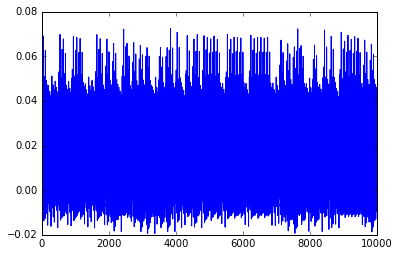

In [29]:
output = np.array(data).reshape(int(len(data)/num_neurons),num_neurons)
output2 = np.array(data2).reshape(int(len(data2)/num_neurons2),num_neurons2)

plt.plot(output[:steps,1])

plt.show()

In [18]:
esn_inputs = []

for n in populations['unknown-visual']['neurons']:
    # Split to find out if its in the input neurons, and if so what cartridge
    (n_class,n_cart) = n.split('-')
    if n_class in input_neurons:
        
        # names is the names associated with experimental_inputs
        pos = names.index(n_cart)
        esn_inputs.append(experiment_data[pos,:])
    else:
        esn_inputs.append(np.zeros((1,experiment_data.shape[1])))


In [19]:
esn_inputs = np.vstack(esn_inputs)

In [20]:
esn_inputs.shape

(70, 10000)

In [21]:
def fit(inputs, states, outputs, inspect=False,output_nodes = None):
    """
    Collect the network's reaction to training data, train readout weights.

    Args:
        inputs: array of dimensions (N_training_samples x n_inputs)
        outputs: array of dimension (N_training_samples x n_outputs)
        inspect: show a visualisation of the collected reservoir states

    Returns:
        the network's output on the training data, using the trained weights
    """
    
    n_reservoir = states.shape[0]
    out_activation=lambda x: x
    inverse_out_activation=lambda x: x
    
    # transform any vectors of shape (x,) into vectors of shape (x,1):
    if inputs.ndim < 2:
        inputs = np.reshape(inputs, (len(inputs), -1))
    if outputs.ndim < 2:
        outputs = np.reshape(outputs, (len(outputs), -1))
    
    full_states = states
    
    # remove the states which have no network output!
    if output_nodes is not None:
        states = output_nodes * states

    # learn the weights, i.e. find the linear combination of collected
    # network states that is closest to the target output
    print("fitting...")

    # we'll disregard the first few states:
    transient = min(int(inputs.shape[1] / 10), 100)
    print transient
    # include the raw inputs:
    extended_states = np.hstack((states, inputs))
    
    print extended_states[transient:, :].shape
    print np.linalg.pinv(extended_states[transient:, :]).shape
    print inverse_out_activation(outputs[transient:, :]).shape
    print outputs.shape
    
    # Solve for W_out:
    W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                        inverse_out_activation(outputs[transient:, :])).T
    
    # optionally visualize the collected states
    from matplotlib import pyplot as plt
    # (^-- we depend on matplotlib only if this option is used)
    plt.figure(
        figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
    plt.imshow(extended_states.T, aspect='auto',
               interpolation='nearest')
    plt.colorbar()

    
    print("training error:")
    # apply learned weights to the collected states:
    pred_train = out_activation(np.dot(extended_states, W_out.T))

    print(np.sqrt(np.mean((pred_train - outputs)**2)))
    return pred_train

In [33]:
train_signal = np.ones((1,steps))
train_signal = experiment_classes.reshape(1,steps)

# input needs to be the same shape as the reservoir
res = fit(esn_inputs.T, output, train_signal.T, inspect=False,output_nodes = None)

fitting...
7
(9993, 140)
(140, 9993)
(9993, 1)
(10000, 1)
training error:
1.1448315432317622


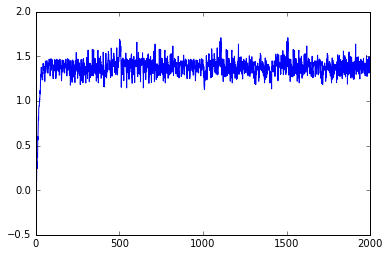

In [36]:
plt.plot(res[0:2000]);
plt.show()
